*Table Of Contents*
- - -
- [Data Shape](#data_shape)
  - [Colosseum scenarios](#data_shape_colosseum_scenarios)
  - [Average over multiple experiment runs](#data_shape_average_over_multiple_runs)
    - [Fix CPI computation time measurements](#data_shape_average_over_fix_cpi)
- [GenSync Performance On Colosseum](#performance_on_colosseum)
  - [Rome Scenario](#results_rome)
  - [Boston and POWDER Scenarios](#results_boston_and_powder)
- - -

In [206]:
%load_ext autoreload
%autoreload 2

from typing import List

# Dependencies
import matplotlib.pyplot as plt
import pandas as pd

# Local
import colosseum_analysis as ca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name="data_shape"></a>
# Data Shape
We can get the raw data using `parse`.

In [207]:
d_1017_raw = ca.parse('plain_data/gensync_985751322_1017.csv')
d_1017_raw

,algorithm,server,client,cardinality,success,bytes transmitted,bytes received,communication time(s),idle time(s),computation time(s)
0,CPI,0,0,10000,True,13.0,62.0,0.480089,0.000000,30.020700
1,CPI,0,0,10000,True,62.0,13.0,0.359874,0.265700,0.000033
2,CPI,0,0,10000,True,13.0,62.0,0.480092,0.000000,0.130434
3,CPI,0,0,10000,True,62.0,13.0,0.359872,0.286035,0.000028
4,CPI,0,0,10000,True,13.0,62.0,0.479927,0.000000,0.129543
...,...,...,...,...,...,...,...,...,...,...
1315,Cuckoo,1000,1000,10000,True,36023.0,35964.0,0.548040,0.081242,0.038412
1316,Cuckoo,1000,1000,10000,True,21590.0,36023.0,0.441711,0.000000,0.040792
1317,Cuckoo,1000,1000,10000,True,36023.0,35964.0,0.546906,0.081442,0.039721
1318,Cuckoo,1000,1000,10000,True,21590.0,36023.0,0.441867,0.000000,0.040778


Each data set parsed this way contains an even number of rows. A row with an even index represents the *GenSync* server's view, while rows with odd indices represent the corresponding client views.

We can also get summary dataset using the `summarize` option.

In [208]:
d_1017 = ca.parse('plain_data/gensync_985751322_1017.csv', summarize=True)
d_1017

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
0,CPI,0,10000,True,75.0,30.500789
1,CPI,0,10000,True,75.0,0.645935
2,CPI,0,10000,True,75.0,0.645802
3,CPI,0,10000,True,75.0,0.620693
4,CPI,0,10000,True,75.0,28.222602
...,...,...,...,...,...,...
655,Cuckoo,1000,10000,True,71987.0,0.658211
656,Cuckoo,1000,10000,True,71987.0,0.679445
657,Cuckoo,1000,10000,True,71987.0,0.667694
658,Cuckoo,1000,10000,True,71987.0,0.668069


Here each row represents one experiment run. `bytes exchanged` is the summary communication among the peers. `ttr` is the total time to reconcile.
Total time to reconcile (TTR) is obtained by combining each pair of rows in the raw data using 

$$TTR = \max_{server, client}( computeTime + communicationTime + idleTime ).$$

And the communication cost (COM) is obtained by summing `bytes transmitted` and `bytes received`.

To get the number of experiment runs for each `algorithm`, `diffs` and `cardinality`:

In [209]:
d_1017_groups = d_1017.groupby(['algorithm', 'diffs', 'cardinality'])
len(d_1017_groups.groups[('CPI', 10, 10000)])

10

The number of different cardinalities in the data set is

In [210]:
len(d_1017['cardinality'].unique())

1

<a name="data_shape_colosseum_scenarios"></a>
## Colosseum Scenarios
Each `csv` file is obtained under single Colosseum cellular [scenario](https://colosseumneu.freshdesk.com/support/solutions/articles/61000295793). 

Next we plot the TTR performance of the three algorithms against differences count under scenario 1017. `d_1017` contains the measurements for the "Rome" scenario where devices are static and close to the base station (within 20 m). `d_1018` holds data for the similar scenario where the devices move moderately (up to 3 m/s).

In [211]:
d_1018 = ca.parse('plain_data/gensync_974396656_1018.csv', summarize=True)

<a name="data_shape_average_over_multiple_runs"></a>
## Average over multiple experiment runs
How many experiment runs is enough to get reasonably accurate mean TTR over all experiment runs?

First off, do all algorithms have similar statistical features?

In [212]:
d_1017_CPI_10 = d_1017.loc[d_1017_groups.groups[('CPI', 10, 10000)]]
d_1017_CPI_10

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
330,CPI,10,10000,True,231.0,30.568804
331,CPI,10,10000,True,231.0,28.721739
332,CPI,10,10000,True,231.0,1.624702
333,CPI,10,10000,True,231.0,5.382294
334,CPI,10,10000,True,231.0,26.898956
335,CPI,10,10000,True,231.0,0.822753
336,CPI,10,10000,True,231.0,0.885706
337,CPI,10,10000,True,231.0,0.638614
338,CPI,10,10000,True,231.0,0.652970
339,CPI,10,10000,True,231.0,5.465376


Why do some of these runs have this huge `ttr`?
- Some runs just have very high computation times.

In [213]:
d_1017_raw[(d_1017_raw['algorithm'] == 'CPI') & (d_1017_raw['server'] == 10)]

,algorithm,server,client,cardinality,success,bytes transmitted,bytes received,communication time(s),idle time(s),computation time(s)
660,CPI,10,10,10000,True,89.0,142.0,0.480904,0.000000,30.087900
661,CPI,10,10,10000,True,142.0,89.0,0.361817,0.262686,0.000084
662,CPI,10,10,10000,True,89.0,142.0,0.481239,0.000000,28.240500
663,CPI,10,10,10000,True,142.0,89.0,0.362096,0.283720,0.000105
664,CPI,10,10,10000,True,89.0,142.0,0.481402,0.000000,1.143300
665,CPI,10,10,10000,True,142.0,89.0,0.361839,0.294377,0.000081
666,CPI,10,10,10000,True,89.0,142.0,0.481154,0.000000,4.901140
667,CPI,10,10,10000,True,142.0,89.0,0.361877,0.291904,0.000074
668,CPI,10,10,10000,True,89.0,142.0,0.480956,0.000000,26.418000
669,CPI,10,10,10000,True,142.0,89.0,0.362078,0.261530,0.000083


The statistics of CPI with 10 differences is

In [214]:
d_1017_CPI_10['ttr'].describe()

count    10.000000
mean     10.166191
std      12.966641
min       0.638614
25%       0.838491
50%       3.503498
75%      21.540561
max      30.568804
Name: ttr, dtype: float64

Text(0.5, 1.0, 'CPI')

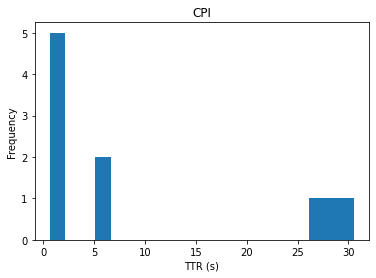

In [215]:
ax = d_1017_CPI_10['ttr'].plot.hist(bins=20)
ax.set_xlabel('TTR (s)')
ax.set_title('CPI')

The variance is very high, it's hard to tell whether these on the far right are outliers. And it appears to hold for many different `diff` values.

In [216]:
diffs_of_interest = range(200, 1100, 100)
cpi_all_d = [d_1017.loc[d_1017_groups.groups[('CPI', i, 10000)]] for i in diffs_of_interest]
for d, i in zip(cpi_all_d, diffs_of_interest):
    print(f"For diffs = {i}\n{d.describe()}")

For diffs = 200
       bytes exchanged        ttr
count             10.0  10.000000
mean            3271.0  22.676541
std                0.0  11.511230
min             3271.0   0.888714
25%             3271.0  27.502187
50%             3271.0  27.588068
75%             3271.0  27.737027
max             3271.0  30.848822
For diffs = 300
       bytes exchanged        ttr
count        10.000000  10.000000
mean       4870.900000  14.479567
std           0.316228  13.809552
min        4870.000000   1.358848
25%        4871.000000   1.371767
50%        4871.000000  14.379007
75%        4871.000000  27.393471
max        4871.000000  28.372030
For diffs = 400
       bytes exchanged        ttr
count        10.000000  10.000000
mean       6470.800000  14.900072
std           0.421637  13.413069
min        6470.000000   2.099767
25%        6471.000000   2.208884
50%        6471.000000  14.644735
75%        6471.000000  27.076657
max        6471.000000  29.752376
For diffs = 500
       bytes excha

Does this happen with other algorithms?

Text(0.5, 0, 'TTR (s)')

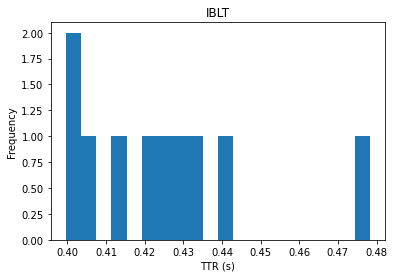

In [217]:
d_1017_IBLT_200 = d_1017.loc[d_1017_groups.groups[('IBLT', 200, 10000)]]
ax = d_1017_IBLT_200['ttr'].plot.hist(bins=20)
ax.set_title('IBLT')
ax.set_xlabel('TTR (s)')

Text(0.5, 0, 'TTR (s)')

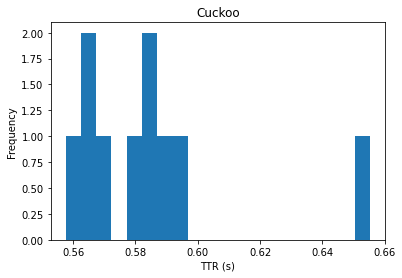

In [218]:
d_1017_Cuckoo_200 = d_1017.loc[d_1017_groups.groups[('Cuckoo', 200, 10000)]]
ax = d_1017_Cuckoo_200['ttr'].plot.hist(bins=20)
ax.set_title('Cuckoo')
ax.set_xlabel('TTR (s)')

- No. Only with CPI.

How many experiment runs we need to reach some reasonable confidence in estimating TTR for CPI?
- Maybe 100?

The following are the experiments for only CPI where each experiment is repeated 100 times. The experiments are partially done (reservation was 6 hours long and got interrupted before completion).

In [219]:
d_1017_CPI_only = ca.parse('plain_data/gensync_464242008_1017_CPI_only.csv', summarize=True)
d_1017_CPI_only[d_1017_CPI_only['diffs'] == 90]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
0,CPI,90,10000,True,1511.0,0.751583
1,CPI,90,10000,True,1511.0,26.837222
2,CPI,90,10000,True,1511.0,27.981921
3,CPI,90,10000,True,1511.0,27.993825
4,CPI,90,10000,True,1511.0,0.747939
...,...,...,...,...,...,...
95,CPI,90,10000,True,1511.0,28.002335
96,CPI,90,10000,True,1511.0,0.734917
97,CPI,90,10000,True,1511.0,27.961921
98,CPI,90,10000,True,1511.0,0.753598


In [220]:
d_1017_CPI_only[d_1017_CPI_only['diffs'] == 90]['ttr'].describe()

count    100.000000
mean      16.193078
std       13.429459
min        0.716781
25%        0.736996
50%       27.378014
75%       27.974657
max       28.004620
Name: ttr, dtype: float64

Text(0.5, 1.0, 'CPI')

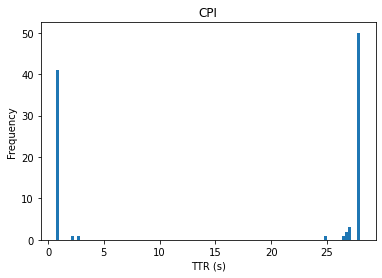

In [221]:
ax = d_1017_CPI_only[d_1017_CPI_only['diffs'] == 90]['ttr'].plot.hist(bins=100)
ax.set_xlabel('TTR (s)')
ax.set_title('CPI')

Does it still comes from the compute time?

In [222]:
d_1017_CPI_only_raw = ca.parse('plain_data/gensync_464242008_1017_CPI_only.csv')
d_1017_CPI_only_raw_50 = d_1017_CPI_only_raw[d_1017_CPI_only_raw['server'] == 50]
d_1017_CPI_only_raw_50

,algorithm,server,client,cardinality,success,bytes transmitted,bytes received,communication time(s),idle time(s),computation time(s)
800,CPI,50,50,10000,True,409.0,462.0,0.483284,0.000000,0.193982
801,CPI,50,50,10000,True,462.0,409.0,0.386473,0.295366,0.000204
802,CPI,50,50,10000,True,409.0,462.0,0.483268,0.000000,0.151828
803,CPI,50,50,10000,True,462.0,409.0,0.377268,0.283237,0.000206
804,CPI,50,50,10000,True,409.0,462.0,0.483109,0.000000,27.645100
...,...,...,...,...,...,...,...,...,...,...
995,CPI,50,50,10000,True,462.0,409.0,0.377456,0.266922,0.000220
996,CPI,50,50,10000,True,409.0,462.0,0.483345,0.000000,27.651500
997,CPI,50,50,10000,True,462.0,409.0,0.377234,0.284560,0.000220
998,CPI,50,50,10000,True,409.0,462.0,0.483218,0.000000,0.165392


In [223]:
d_1017_CPI_only_raw_50['communication time(s)'].describe()

count    200.000000
mean       0.430668
std        0.052801
min        0.376361
25%        0.377332
50%        0.434787
75%        0.483302
max        0.483617
Name: communication time(s), dtype: float64

In [224]:
d_1017_CPI_only_raw_50['idle time(s)'].describe()

count    200.000000
mean       0.141664
std        0.142407
min        0.000000
25%        0.000000
50%        0.129233
75%        0.283249
max        0.314135
Name: idle time(s), dtype: float64

In [225]:
d_1017_CPI_only_raw_50['computation time(s)'].describe()

count    200.000000
mean       6.680225
std       11.774092
min        0.000203
25%        0.000215
50%        0.062938
75%        1.162057
max       28.019600
Name: computation time(s), dtype: float64

Is this computation time only on the server side?

In [226]:
[x for x in d_1017_CPI_only_raw_50[d_1017_CPI_only_raw_50['computation time(s)'] > 15].index if x % 2]

[]

Thus, it seems like it's only on the server side.

<a name="data_shape_average_over_fix_cpi"></a>
### Fix CPI computation time measurements

It turns out that our CPI server computation time measurements were not implemented correctly when GenSync is compiled with `IGNORE_SERVER_IDLE` option. Now it is fixed and CPI experiments are rerun.

In [227]:
d_1017_fix = ca.parse('plain_data/gensync_151036073_1017.csv', summarize=True)
d_1017_fix[d_1017_fix['diffs'] == 50]['ttr'].describe()

count    10.000000
mean      0.662244
std       0.021494
min       0.639352
25%       0.646105
50%       0.658789
75%       0.671983
max       0.710914
Name: ttr, dtype: float64

Next, we will combine the data frames from this experiment with the one from the previous runs.

In [228]:
d_1017 = ca.fix(d_1017, d_1017_fix)
d_1017[(d_1017['algorithm'] == 'CPI') & (d_1017['diffs'] == 10)]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
520,CPI,10,10000,True,231.0,0.644389
521,CPI,10,10000,True,231.0,0.660261
522,CPI,10,10000,True,231.0,0.648104
523,CPI,10,10000,True,231.0,0.632232
524,CPI,10,10000,True,231.0,0.620704
525,CPI,10,10000,True,231.0,0.657554
526,CPI,10,10000,True,231.0,0.655473
527,CPI,10,10000,True,231.0,0.654131
528,CPI,10,10000,True,231.0,0.622770
529,CPI,10,10000,True,231.0,0.637173


In [229]:
d_1017.shape

(660, 6)

In [230]:
d_1018_fix = ca.parse('plain_data/gensync_968760679_1018.csv', summarize=True)
d_1018 = ca.fix(d_1018, d_1018_fix)
d_1018[(d_1018['algorithm'] == 'CPI') & (d_1018['diffs'] == 10)]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
520,CPI,10,10000,True,231.0,0.653457
521,CPI,10,10000,True,231.0,0.644646
522,CPI,10,10000,True,231.0,0.652675
523,CPI,10,10000,True,231.0,0.629291
524,CPI,10,10000,True,231.0,0.655896
525,CPI,10,10000,True,231.0,0.633967
526,CPI,10,10000,True,231.0,0.634764
527,CPI,10,10000,True,231.0,0.656365
528,CPI,10,10000,True,231.0,0.643659
529,CPI,10,10000,True,231.0,0.637199


The data is now more accurate.

<a name="performance_on_colosseum"></a>
# GenSync Performance On Colosseum
We analyze the initial results obtained from the following scenarios:
- Rome close static (1017): 3 user devices, 1 base station, users are static and within 20 m from the base station, and
- Rome close moderate (1018): users are moving at ~3 m/s within 20 m from the base station.
- Rome far static (1019): users are static, but further from the base station (within 100 m).
- Boston close static (1031)
- Boston close moderate (1033)
- Boston far static (1024)
- POWDER close static (1025)
- POWDER close moderate (1026)
- POWDER far static (1027)

Data parameters are $|S_A| = |S_B| = 10000$ and $10 <= d <= 1000$. Each experiment is repeated 10 times.

In these experiments, synchronization is done among two users while the third is idle (does not transmit or receive any traffic).

<a name="#results_rome"></a>
## Rome Scenario

In [231]:
def get_algo_data(algo: str, data: pd.DataFrame):
    return data[data['algorithm'] == algo]

In [232]:
CPI_1017 = get_algo_data('CPI', d_1017)
IBLT_1017 = get_algo_data('IBLT', d_1017)
Cuckoo_1017 = get_algo_data('Cuckoo', d_1017)

In [233]:
CPI_1018 = get_algo_data('CPI', d_1018)
IBLT_1018 = get_algo_data('IBLT', d_1018)
Cuckoo_1018 = get_algo_data('Cuckoo', d_1018)

In [234]:
def get_xs_ys(data: pd.DataFrame): 
    g = data.groupby('diffs')
    diffs = g.groups.keys()
    stat = g.apply(lambda x: x.describe())['ttr']
    ttrs = [stat.xs(d)['mean'] for d in diffs]
    return diffs, ttrs

In [253]:
def plot_ttr(data: List[pd.DataFrame], labels: List[str], axis=plt, title=None) -> None:
    x_label = 'Symmetric Differences (d)'
    y_label = 'TTR (s)'
    
    for d in data:
        xs, ys = get_xs_ys(d)
        axis.plot(xs, ys)
        
    axis.legend(labels)
    axis.xlabel(x_label) if type(axis) == type(plt) else axis.set_xlabel(x_label)
    axis.ylabel(y_label) if type(axis) == type(plt) else axis.set_ylabel(y_label)
    if title:
        axis.title(title) if type(axis) == type(plt) else axis.set_title(title)

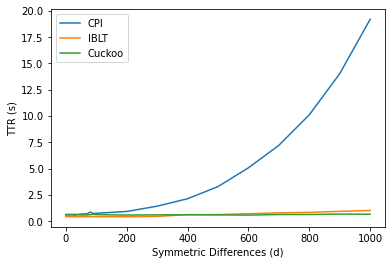

In [254]:
plot_ttr([CPI_1017, IBLT_1017, Cuckoo_1017], ['CPI', 'IBLT', 'Cuckoo'])

Above is what happens when the nodes are static. The following is what happens when the nodes move moderately (*i.e*, at about 3 m/s)

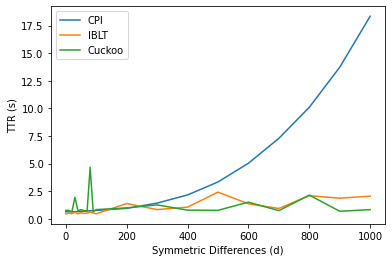

In [237]:
plot_ttr([CPI_1018, IBLT_1018, Cuckoo_1018], ['CPI', 'IBLT', 'Cuckoo'])

Next, let's plot what happens when the nodes are static but now at around 100 m.

In [238]:
d_1019 = ca.parse('plain_data/gensync_716773447_1019.csv', summarize=True)

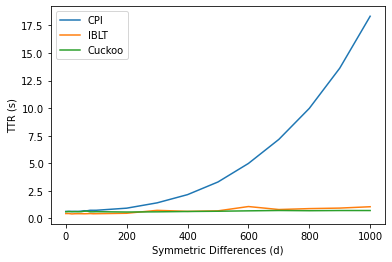

In [239]:
CPI_1019 = get_algo_data('CPI', d_1019)
IBLT_1019 = get_algo_data('IBLT', d_1019)
Cuckoo_1019 = get_algo_data('Cuckoo', d_1019)

plot_ttr([CPI_1019, IBLT_1019, Cuckoo_1019], ['CPI', 'IBLT', 'Cuckoo'])

Which does not differ significantly from the plot when the nodes were within 20 m from the base station. In conclusion, **movements affect the performance** of our algorithms more than the distance from the base station.

<a name="#results_boston_and_powder"></a>
## Boston and POWDER Scenarios

In [240]:
d_1031 = ca.parse('plain_data/gensync_203947479_1031.csv', summarize=True)
d_1033 = ca.parse('plain_data/gensync_849071254_1033.csv', summarize=True)
d_1024 = ca.parse('plain_data/gensync_020381165_1024.csv', summarize=True)

In [241]:
CPI_1031 = get_algo_data('CPI', d_1031)
IBLT_1031 = get_algo_data('IBLT', d_1031)
Cuckoo_1031 = get_algo_data('Cuckoo', d_1031)

CPI_1033 = get_algo_data('CPI', d_1033)
IBLT_1033 = get_algo_data('IBLT', d_1033)
Cuckoo_1033 = get_algo_data('Cuckoo', d_1033)

CPI_1024 = get_algo_data('CPI', d_1024)
IBLT_1024 = get_algo_data('IBLT', d_1024)
Cuckoo_1024 = get_algo_data('Cuckoo', d_1024)

Text(0.5, 0.98, 'Boston')

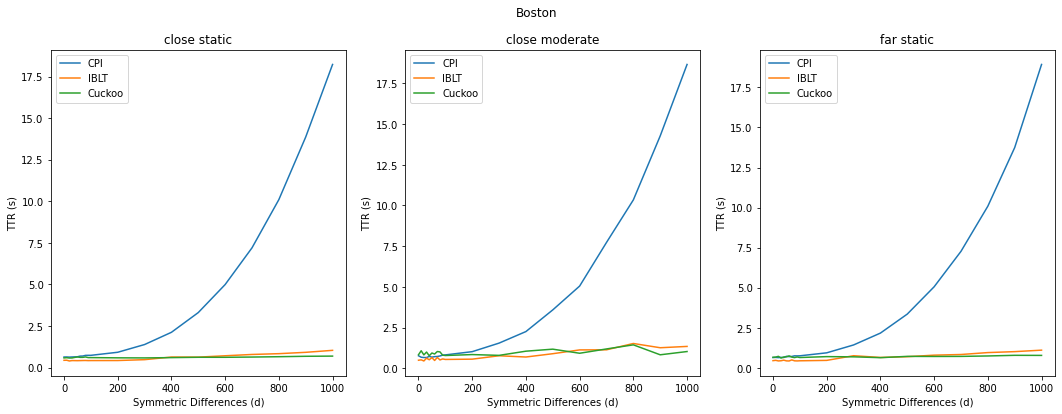

In [264]:
figure, axis = plt.subplots(1, 3, figsize=(18, 6))
plot_ttr([CPI_1031, IBLT_1031, Cuckoo_1031], ['CPI', 'IBLT', 'Cuckoo'], title='close static', axis=axis[0])
plot_ttr([CPI_1033, IBLT_1033, Cuckoo_1033], ['CPI', 'IBLT', 'Cuckoo'], title='close moderate', axis=axis[1])
plot_ttr([CPI_1024, IBLT_1024, Cuckoo_1024], ['CPI', 'IBLT', 'Cuckoo'], title='far static', axis=axis[2])
figure.suptitle('Boston')

In [269]:
d_1025 = ca.parse('plain_data/gensync_081328890_1025.csv', summarize=True)
d_1026 = ca.parse('plain_data/gensync_909483837_1026.csv', summarize=True)
d_1027 = ca.parse('plain_data/gensync_863458421_1027.csv', summarize=True)

In [272]:
CPI_1025 = get_algo_data('CPI', d_1025)
IBLT_1025 = get_algo_data('IBLT', d_1025)
Cuckoo_1025 = get_algo_data('Cuckoo', d_1025)

# CPI_1026 = get_algo_data('CPI', d_1026)
# IBLT_1026 = get_algo_data('IBLT', d_1026)
# Cuckoo_1026 = get_algo_data('Cuckoo', d_1026)

CPI_1027 = get_algo_data('CPI', d_1027)
IBLT_1027 = get_algo_data('IBLT', d_1027)
Cuckoo_1027 = get_algo_data('Cuckoo', d_1027)

In [280]:
d_1026.shape

(80, 6)

In [281]:
d_1027.shape

(660, 6)

**TODO**: There is something wrong with scenario 1026. Only 80 columns, while others have 660.

Text(0.5, 0.98, 'POWDER')

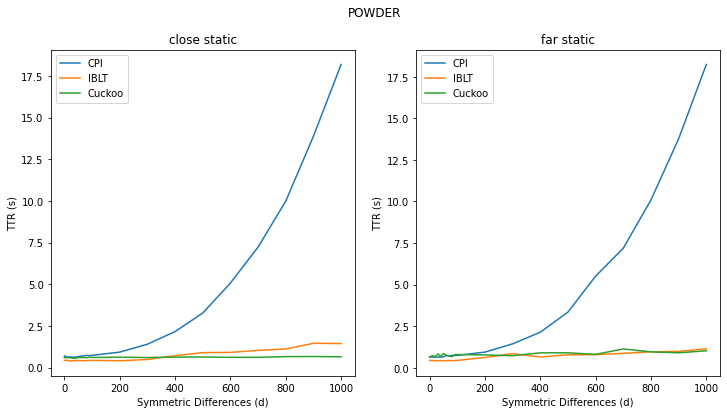

In [283]:
figure, axis = plt.subplots(1, 2, figsize=(12, 6))
plot_ttr([CPI_1025, IBLT_1025, Cuckoo_1025], ['CPI', 'IBLT', 'Cuckoo'], title='close static', axis=axis[0])
#plot_ttr([CPI_1026, IBLT_1026, Cuckoo_1026], ['CPI', 'IBLT', 'Cuckoo'], title='close moderate', axis=axis[1])
plot_ttr([CPI_1027, IBLT_1027, Cuckoo_1027], ['CPI', 'IBLT', 'Cuckoo'], title='far static', axis=axis[1])
figure.suptitle('POWDER')